# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 379 µs (started: 2023-02-18 04:28:12 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, 
    Dense, Dropout, Input, Concatenate, 
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.19 s (started: 2023-02-18 04:28:12 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

print('versión Keras:', keras.__version__)

versión Keras: 2.11.0
time: 953 µs (started: 2023-02-18 04:28:15 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 1.64 s (started: 2023-02-18 04:28:15 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):
    '''Crea un modelo de Deep Learning
    '''
    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_9G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(custom_model, WEIGHTS_PATH):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
         -WEIGHTS_PATH = Ruta en drive a la carpeta de los pesos
        -custom_model = Modelo de Deep Learning
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print('------ Model Saved -------')


time: 8.21 ms (started: 2023-02-18 04:28:17 +00:00)


# Imgs 64x64

- Test Accuracy: 0.1277403086423874
- Test Loss: 5.818229675292969
- time: 2h 9min 48s
- F1 score: 0.11041455390177471
- Precision score: 0.20301551716508595
- Recall:  0.12774030354131535
- Epoch: 50/50

## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 553 µs (started: 2023-02-16 16:26:06 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24 s (started: 2023-02-16 16:26:07 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.51 ms (started: 2023-02-16 16:26:31 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 3.31 s (started: 2023-02-16 16:26:31 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 170s 11ms/step - loss: 7.9378 - sparse_categorical_accuracy: 0.0018 - val_loss: 7.8516 - val_sparse_categorical_accuracy: 0.0044
Epoch 2/50
13899/13899 [==============================] - 172s 12ms/step - loss: 7.7775 - sparse_categorical_accuracy: 0.0057 - val_loss: 7.7188 - val_sparse_categorical_accuracy: 0.0074
Epoch 3/50
13899/13899 [==============================] - 176s 13ms/step - loss: 7.6498 - sparse_categorical_accuracy: 0.0102 - val_loss: 7.6015 - val_sparse_categorical_accuracy: 0.0103
Epoch 4/50
13899/13899 [==============================] - 156s 11ms/step - loss: 7.5377 - sparse_categorical_accuracy: 0.0139 - val_loss: 7.4997 - val_sparse_categorical_accuracy: 0.0140
Epoch 5/50
13899/13899 [==============================] - 156s 11ms/step - loss: 7.4374 - sparse_categorical_accuracy: 0.0182 - val_loss: 7.4086 - val_sparse_categorical_accuracy: 0.0196
Epoch 6/50
13899/13899 [==============================] - 166s 12

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.87 s (started: 2023-02-16 18:36:23 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 16s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.1277403086423874
- Test Loss: 5.818229675292969
- time: 
- F1 score: 0.11041455390177471
- Precision score: 0.20301551716508595
- Recall:  0.12774030354131535
- Epoch: 
*********************************************************************************************************************************
time: 38.2 s (started: 2023-02-16 18:36:27 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

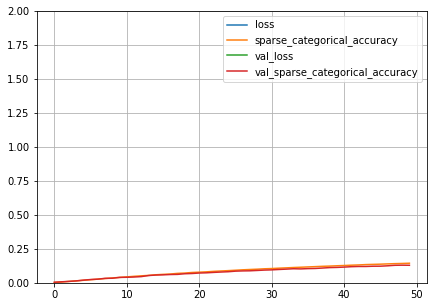

time: 329 ms (started: 2023-02-16 18:37:05 +00:00)


In [ ]:
plot_loss(history)

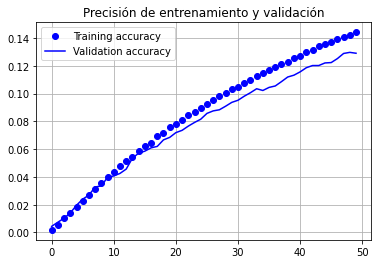

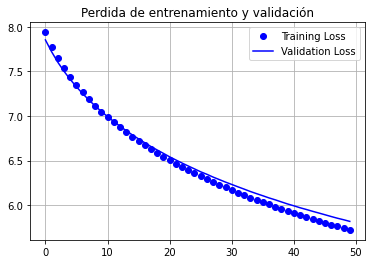

time: 375 ms (started: 2023-02-16 18:37:06 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 1.55 s (started: 2023-02-16 18:37:06 +00:00)


# Imgs 96x96

- Test Accuracy: 0.1327318698167801
- Test Loss: 6.062348365783691
- time: 2h 25min 40s
- F1 score: 0.11809255932517058
- Precision score: 0.23719265127964537
- Recall:  0.1327318718381113
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 708 µs (started: 2023-02-16 18:37:08 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 56.9 s (started: 2023-02-16 18:37:08 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 883 µs (started: 2023-02-16 18:38:05 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.68 s (started: 2023-02-16 18:38:05 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 180s 13ms/step - loss: 7.9666 - sparse_categorical_accuracy: 0.0013 - val_loss: 7.9090 - val_sparse_categorical_accuracy: 0.0023
Epoch 2/50
13899/13899 [==============================] - 172s 12ms/step - loss: 7.8602 - sparse_categorical_accuracy: 0.0050 - val_loss: 7.8184 - val_sparse_categorical_accuracy: 0.0075
Epoch 3/50
13899/13899 [==============================] - 173s 12ms/step - loss: 7.7712 - sparse_categorical_accuracy: 0.0086 - val_loss: 7.7356 - val_sparse_categorical_accuracy: 0.0115
Epoch 4/50
13899/13899 [==============================] - 173s 12ms/step - loss: 7.6888 - sparse_categorical_accuracy: 0.0122 - val_loss: 7.6583 - val_sparse_categorical_accuracy: 0.0136
Epoch 5/50
13899/13899 [==============================] - 173s 12ms/step - loss: 7.6117 - sparse_categorical_accuracy: 0.0157 - val_loss: 7.5871 - val_sparse_categorical_accuracy: 0.0167
Epoch 6/50
13899/13899 [==============================] - 173s 12

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 7.22 s (started: 2023-02-16 21:03:48 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 18s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.1327318698167801
- Test Loss: 6.062348365783691
- time: 
- F1 score: 0.11809255932517058
- Precision score: 0.23719265127964537
- Recall:  0.1327318718381113
- Epoch: 
*********************************************************************************************************************************
time: 43.4 s (started: 2023-02-16 21:03:55 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

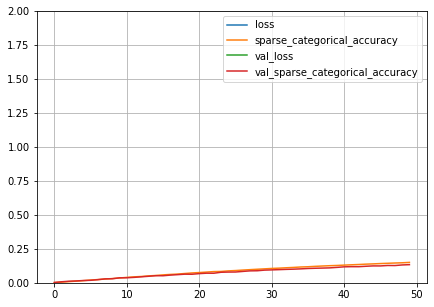

time: 206 ms (started: 2023-02-16 21:04:38 +00:00)


In [ ]:
plot_loss(history)

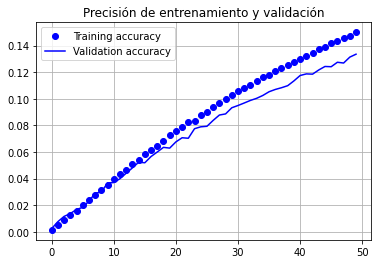

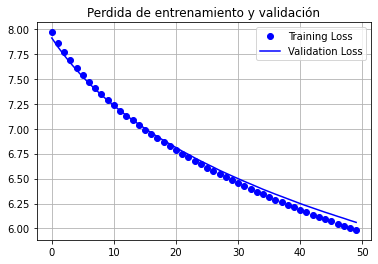

time: 403 ms (started: 2023-02-16 21:04:39 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 736 ms (started: 2023-02-16 21:04:39 +00:00)


# Imgs 112x112

- Test Accuracy: 0.2790219187736511
- Test Loss: 4.31621789932251
- time: 2h 28min 1s
- F1 score: 0.2673842417850722
- Precision score: 0.40281572647672387
- Recall:  0.2790219224283305
- Epoch: 50/50



## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 556 µs (started: 2023-02-16 21:13:15 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 22s (started: 2023-02-16 21:13:16 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.52 ms (started: 2023-02-16 21:14:38 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 4s 0us/step
time: 9.62 s (started: 2023-02-16 21:14:38 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 112, 112, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 190s 13ms/step - loss: 7.8195 - sparse_categorical_accuracy: 0.0030 - val_loss: 7.5960 - val_sparse_categorical_accuracy: 0.0059
Epoch 2/50
13899/13899 [==============================] - 175s 13ms/step - loss: 7.4246 - sparse_categorical_accuracy: 0.0101 - val_loss: 7.2826 - val_sparse_categorical_accuracy: 0.0157
Epoch 3/50
13899/13899 [==============================] - 180s 13ms/step - loss: 7.1492 - sparse_categorical_accuracy: 0.0196 - val_loss: 7.0520 - val_sparse_categorical_accuracy: 0.0208
Epoch 4/50
13899/13899 [==============================] - 182s 13ms/step - loss: 6.9316 - sparse_categorical_accuracy: 0.0292 - val_loss: 6.8591 - val_sparse_categorical_accuracy: 0.0343
Epoch 5/50
13899/13899 [==============================] - 181s 13ms/step - loss: 6.7503 - sparse_categorical_accuracy: 0.0393 - val_loss: 6.7040 - val_sparse_categorical_accuracy: 0.0381
Epoch 6/50
13899/13899 [==============================] - 179s 13

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 11 s (started: 2023-02-16 23:42:50 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 18s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.2790219187736511
- Test Loss: 4.31621789932251
- time: 
- F1 score: 0.2673842417850722
- Precision score: 0.40281572647672387
- Recall:  0.2790219224283305
- Epoch: 
*********************************************************************************************************************************
time: 45.9 s (started: 2023-02-16 23:43:01 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

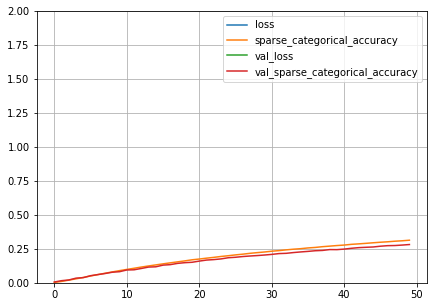

time: 258 ms (started: 2023-02-16 23:43:47 +00:00)


In [ ]:
plot_loss(history)

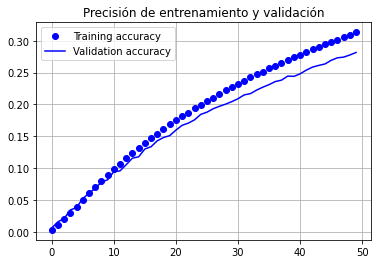

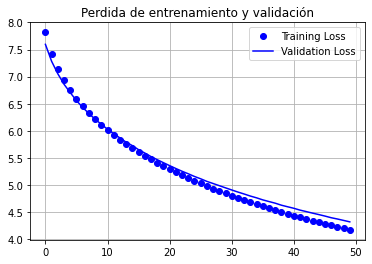

time: 401 ms (started: 2023-02-16 23:43:47 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 2.25 s (started: 2023-02-16 23:43:47 +00:00)


# Imgs 127x127

- Test Accuracy: 0.08203203976154327
- Test Loss: 6.712296009063721
- time: 2h 15min 54s
- F1 score: 0.06781316696551937
- Precision score: 0.19953189524359147
- Recall:  0.08203204047217538
- Epoch: 50/50


## Cargar imágenes

In [ ]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_v2/'
PATH = ROOT_PATH.format(SIZE)

print(PATH)

MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
            + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
            + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

print('Weights path:', WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_v2/
Weights path: /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/model_resnet50_etl9_imgs127_regular.h5
time: 1.22 ms (started: 2023-02-18 04:28:25 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 30s (started: 2023-02-18 02:09:01 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (355800, 127, 127, 1) and labels: (355800,)

- val images: (118600, 127, 127, 1) and labels: (118600,)

time: 913 µs (started: 2023-02-18 02:10:31 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 0s 0us/step
time: 5.8 s (started: 2023-02-18 02:10:31 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
11119/11119 [==============================] - 183s 15ms/step - loss: 8.0007 - sparse_categorical_accuracy: 6.4643e-04 - val_loss: 7.9671 - val_sparse_categorical_accuracy: 5.0590e-04
Epoch 2/50
11119/11119 [==============================] - 163s 15ms/step - loss: 7.9422 - sparse_categorical_accuracy: 0.0019 - val_loss: 7.9220 - val_sparse_categorical_accuracy: 0.0021
Epoch 3/50
11119/11119 [==============================] - 163s 15ms/step - loss: 7.8980 - sparse_categorical_accuracy: 0.0032 - val_loss: 7.8806 - val_sparse_categorical_accuracy: 0.0036
Epoch 4/50
11119/11119 [==============================] - 163s 15ms/step - loss: 7.8555 - sparse_categorical_accuracy: 0.0053 - val_loss: 7.8415 - val_sparse_categorical_accuracy: 0.0054
Epoch 5/50
11119/11119 [==============================] - 163s 15ms/step - loss: 7.8147 - sparse_categorical_accuracy: 0.0067 - val_loss: 7.8015 - val_sparse_categorical_accuracy: 0.0067
Epoch 6/50
11119/11119 [==============================] -

## Graficando

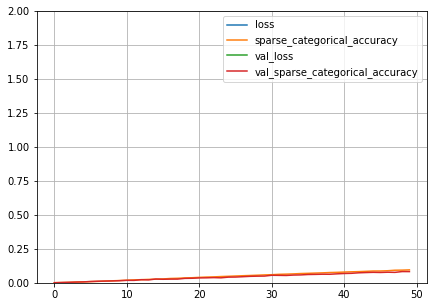

time: 284 ms (started: 2023-02-18 04:26:32 +00:00)


In [ ]:
plot_loss(history)

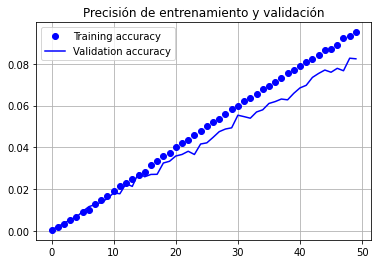

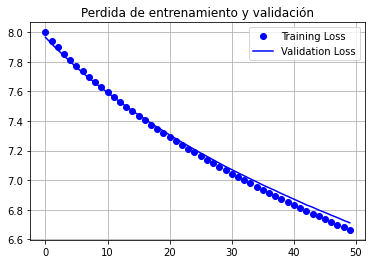

time: 390 ms (started: 2023-02-18 04:26:33 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 1.8 s (started: 2023-02-18 04:26:33 +00:00)


## Métricas

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 22.5 s (started: 2023-02-18 04:28:51 +00:00)


In [ ]:
# Cargar modelo
custom_model = keras.models.load_model(WEIGHTS_PATH)

time: 6.39 s (started: 2023-02-18 04:29:13 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

3707/3707 [==============================] - 37s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.08203203976154327
- Test Loss: 6.712296009063721
- time: 
- F1 score: 0.06781316696551937
- Precision score: 0.19953189524359147
- Recall:  0.08203204047217538
- Epoch: 
*********************************************************************************************************************************
time: 1min 44s (started: 2023-02-18 04:29:20 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
runtime.unassign()
#quit()

time: 198 ms (started: 2023-02-18 04:31:04 +00:00)
